# 手算梯度下降，求解线性回归

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=2, threshold=50)

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

In [4]:
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

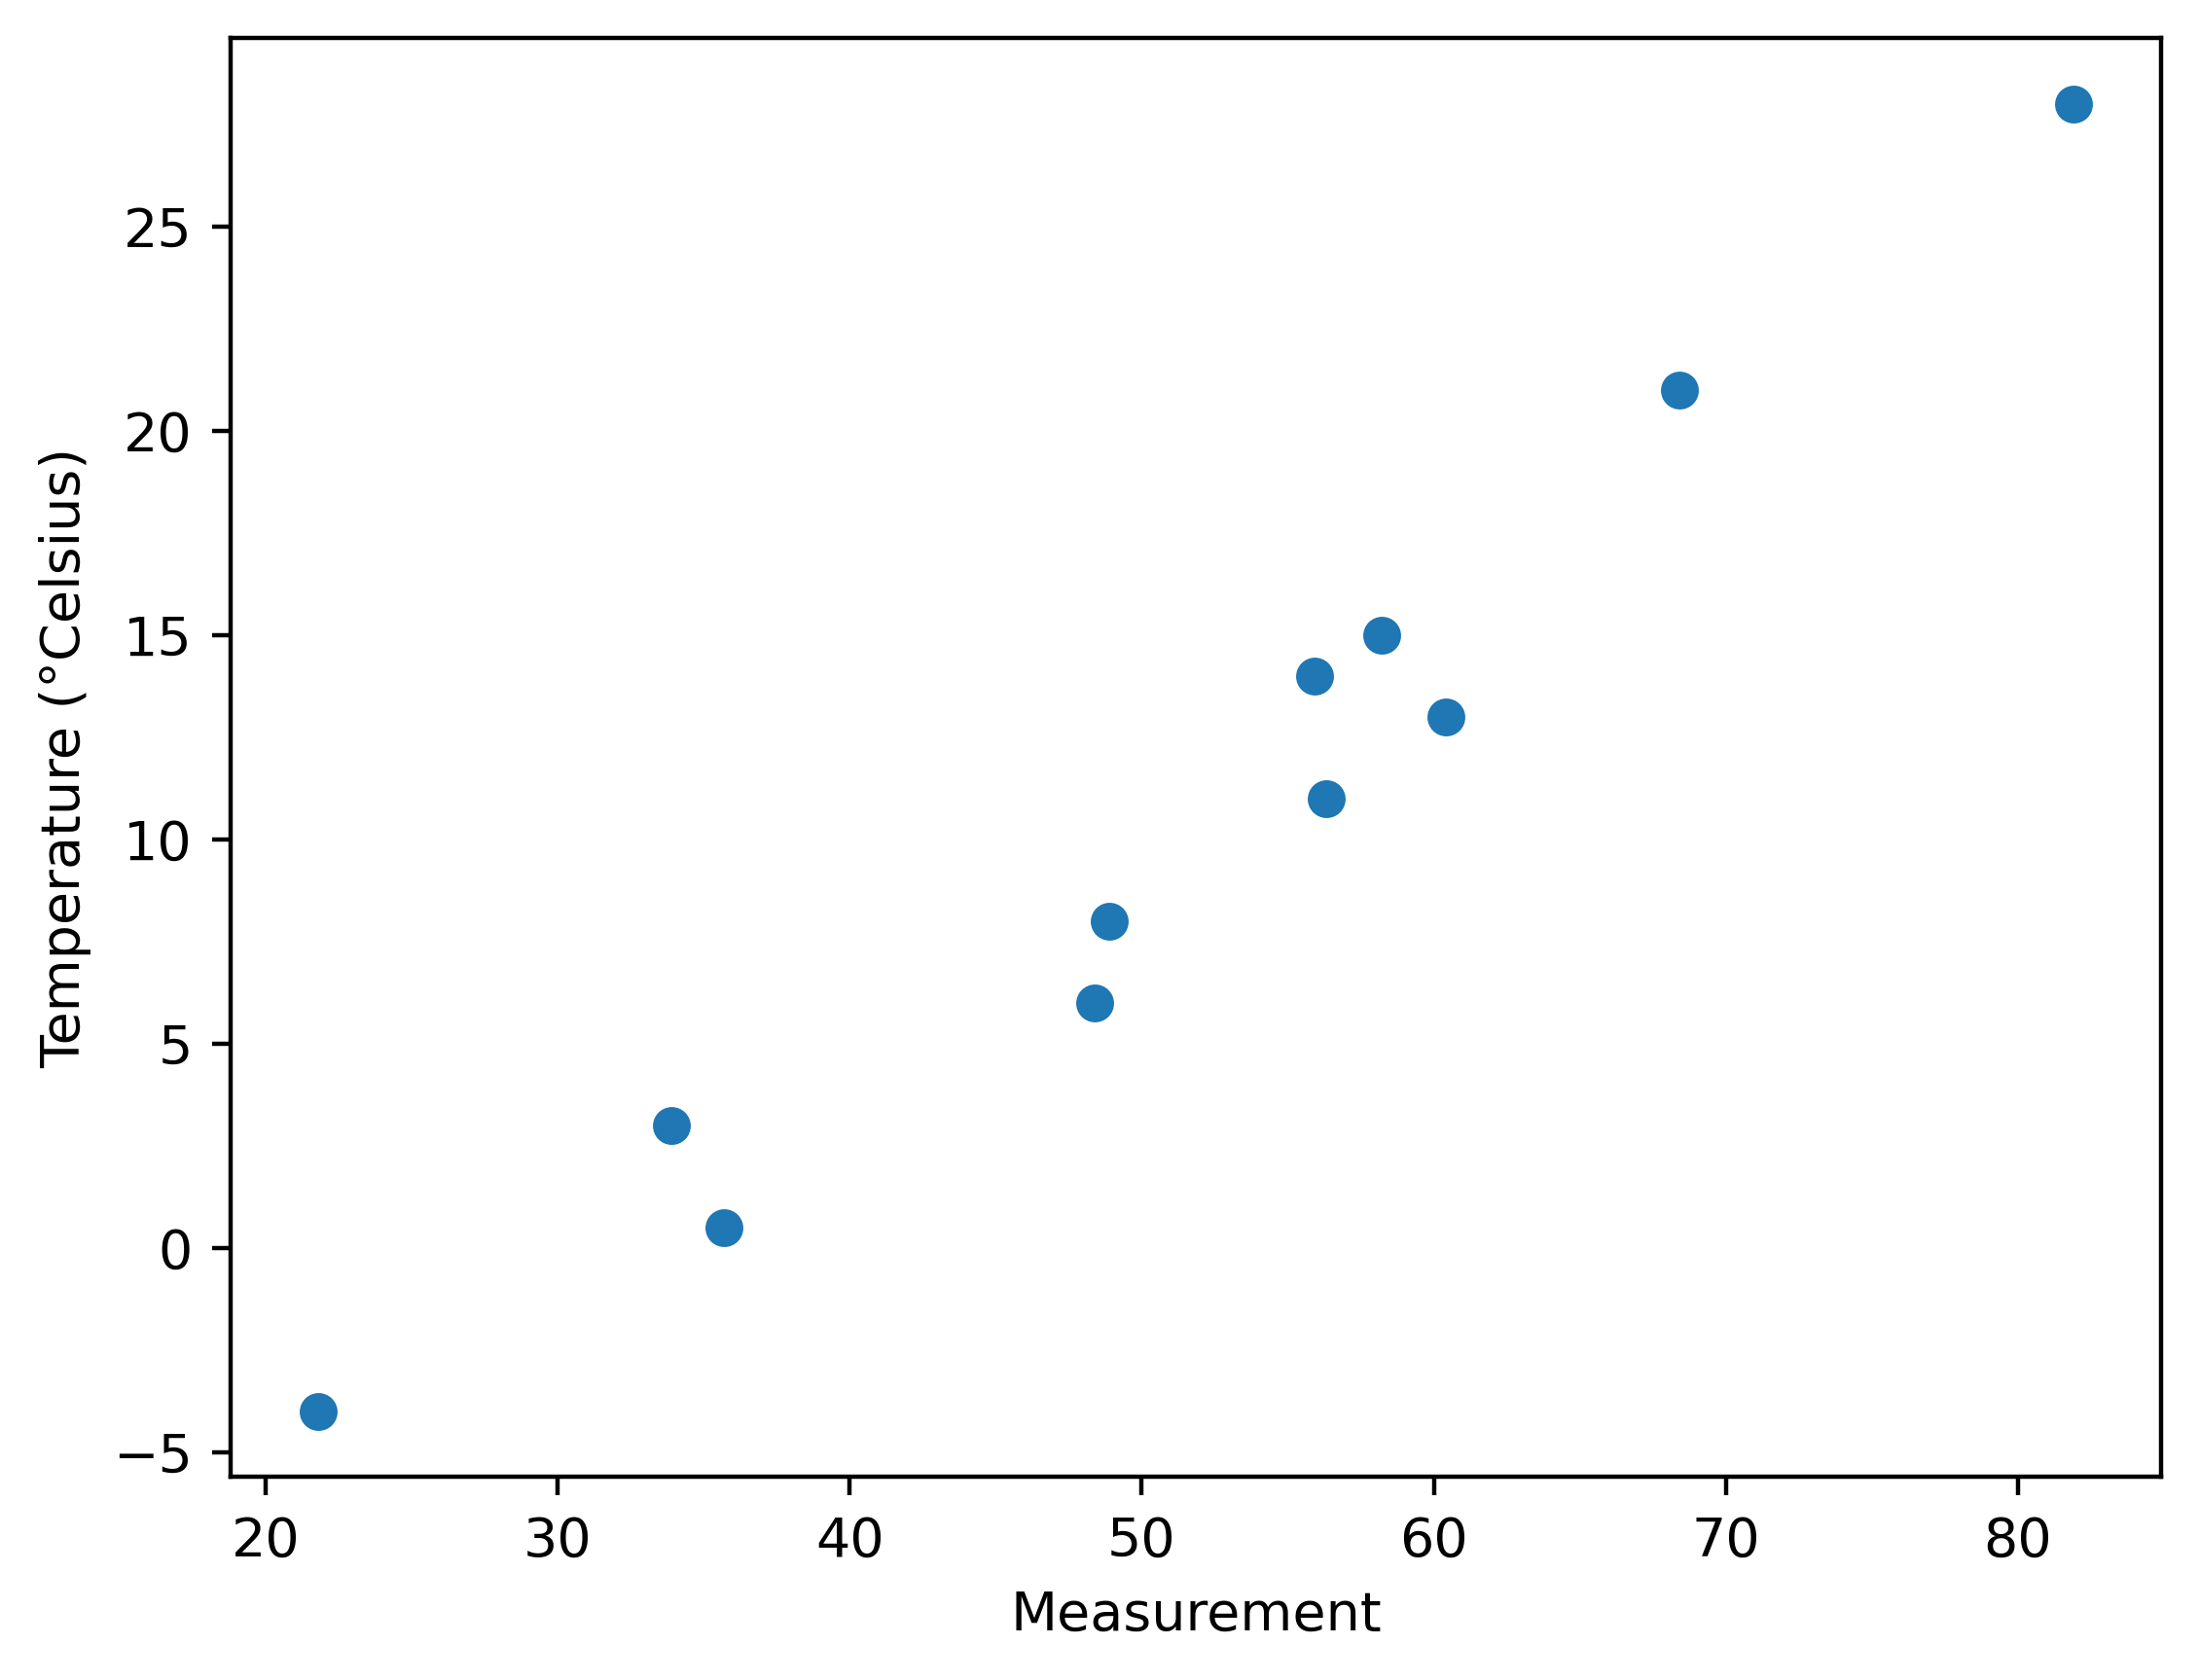

In [5]:
fig = plt.figure(dpi=400)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), "o")

plt.show()

In [7]:
plt.savefig("img/temp_data_plot.png", format="png")

<Figure size 640x480 with 0 Axes>

In [8]:
def model(t_u, w, b):
    return w * t_u + b

In [9]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [10]:
w = torch.ones(())
b = torch.zeros(())
w, b

(tensor(1.), tensor(0.))

In [11]:
t_p = model(t_u, w, b)
t_p, t_c

(tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000]),
 tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
          6.0000, 13.0000, 21.0000]))

In [12]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [13]:
delta = 0.1

In [14]:
loss_rate_of_change_w = (
    loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)
) / (2.0 * delta)

In [15]:
loss_rate_of_change_w

tensor(4517.2974)

In [16]:
learning_rate = 1e-2

In [17]:
w -= learning_rate * loss_rate_of_change_w

In [18]:
loss_rate_of_change_b = (
    loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)
) / (2.0 * delta)
loss_rate_of_change_b

tensor(-4600.)

In [19]:
b -= learning_rate * loss_rate_of_change_b

In [20]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [25]:
def dmodel_dw(t_u, w, b):
    return t_u

In [26]:
def dmodel_db(t_u, w, b):
    return 1.0

In [21]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [22]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        print(f"{epoch = }, {loss = }")
    return params

In [35]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print(f"{epoch = }, {loss = :f}")
            if print_params:
                print(f"    {params = }")
                print(f"    {grad = }")

        if epoch in {4, 12, 101}:
            print("...")

        if not torch.isfinite(loss).all():
            break

    return params

In [38]:
w, b = training_loop(
    n_epochs=100, learning_rate=1e-4, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c
)
w, b

epoch = 1, loss = 1763.884766
    params = tensor([ 0.5483, -0.0083])
    grad = tensor([4517.2964,   82.6000])
epoch = 2, loss = 323.090515
    params = tensor([ 0.3623, -0.0118])
    grad = tensor([1859.5493,   35.7843])
epoch = 3, loss = 78.929634
    params = tensor([ 0.2858, -0.0135])
    grad = tensor([765.4666,  16.5122])
...
epoch = 10, loss = 29.105247
    params = tensor([ 0.2324, -0.0166])
    grad = tensor([1.4803, 3.0544])
epoch = 11, loss = 29.104168
    params = tensor([ 0.2323, -0.0169])
    grad = tensor([0.5781, 3.0384])
...
epoch = 99, loss = 29.023582
    params = tensor([ 0.2327, -0.0435])
    grad = tensor([-0.0533,  3.0226])
epoch = 100, loss = 29.022667
    params = tensor([ 0.2327, -0.0438])
    grad = tensor([-0.0532,  3.0226])


(tensor(0.2327), tensor(-0.0438))

上面当lr设置为1e-2时无法收敛，设置为1e-4才能收敛，下面利用对输入数据进行放缩来使lr不变的情况下使训练收敛

**其实，不管是标准化还是归一化，都只是对数据进行缩放的一种方式，有利于训练收敛**

In [39]:
t_u = 0.1 * t_u

In [40]:
w, b = training_loop(
    n_epochs=100, learning_rate=1e-2, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c
)
w, b

epoch = 1, loss = 80.364342
    params = tensor([1.7761, 0.1064])
    grad = tensor([-77.6140, -10.6400])
epoch = 2, loss = 37.574913
    params = tensor([2.0848, 0.1303])
    grad = tensor([-30.8623,  -2.3864])
epoch = 3, loss = 30.871077
    params = tensor([2.2094, 0.1217])
    grad = tensor([-12.4631,   0.8587])
...
epoch = 10, loss = 29.030489
    params = tensor([ 2.3232, -0.0710])
    grad = tensor([-0.5355,  2.9295])
epoch = 11, loss = 28.941877
    params = tensor([ 2.3284, -0.1003])
    grad = tensor([-0.5240,  2.9264])
...
epoch = 99, loss = 22.214186
    params = tensor([ 2.7508, -2.4910])
    grad = tensor([-0.4453,  2.5208])
epoch = 100, loss = 22.148710
    params = tensor([ 2.7553, -2.5162])
    grad = tensor([-0.4446,  2.5165])


(tensor(2.7553), tensor(-2.5162))

In [41]:
w, b = training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params=torch.tensor([1.0, 0.0]),
    t_u=t_u,
    t_c=t_c,
    print_params=False,
)
w, b

epoch = 1, loss = 80.364342
epoch = 2, loss = 37.574913
epoch = 3, loss = 30.871077
...
epoch = 10, loss = 29.030489
epoch = 11, loss = 28.941877
...
epoch = 99, loss = 22.214186
epoch = 100, loss = 22.148710
...
epoch = 4000, loss = 2.927680
epoch = 5000, loss = 2.927648


(tensor(5.3671), tensor(-17.3012))

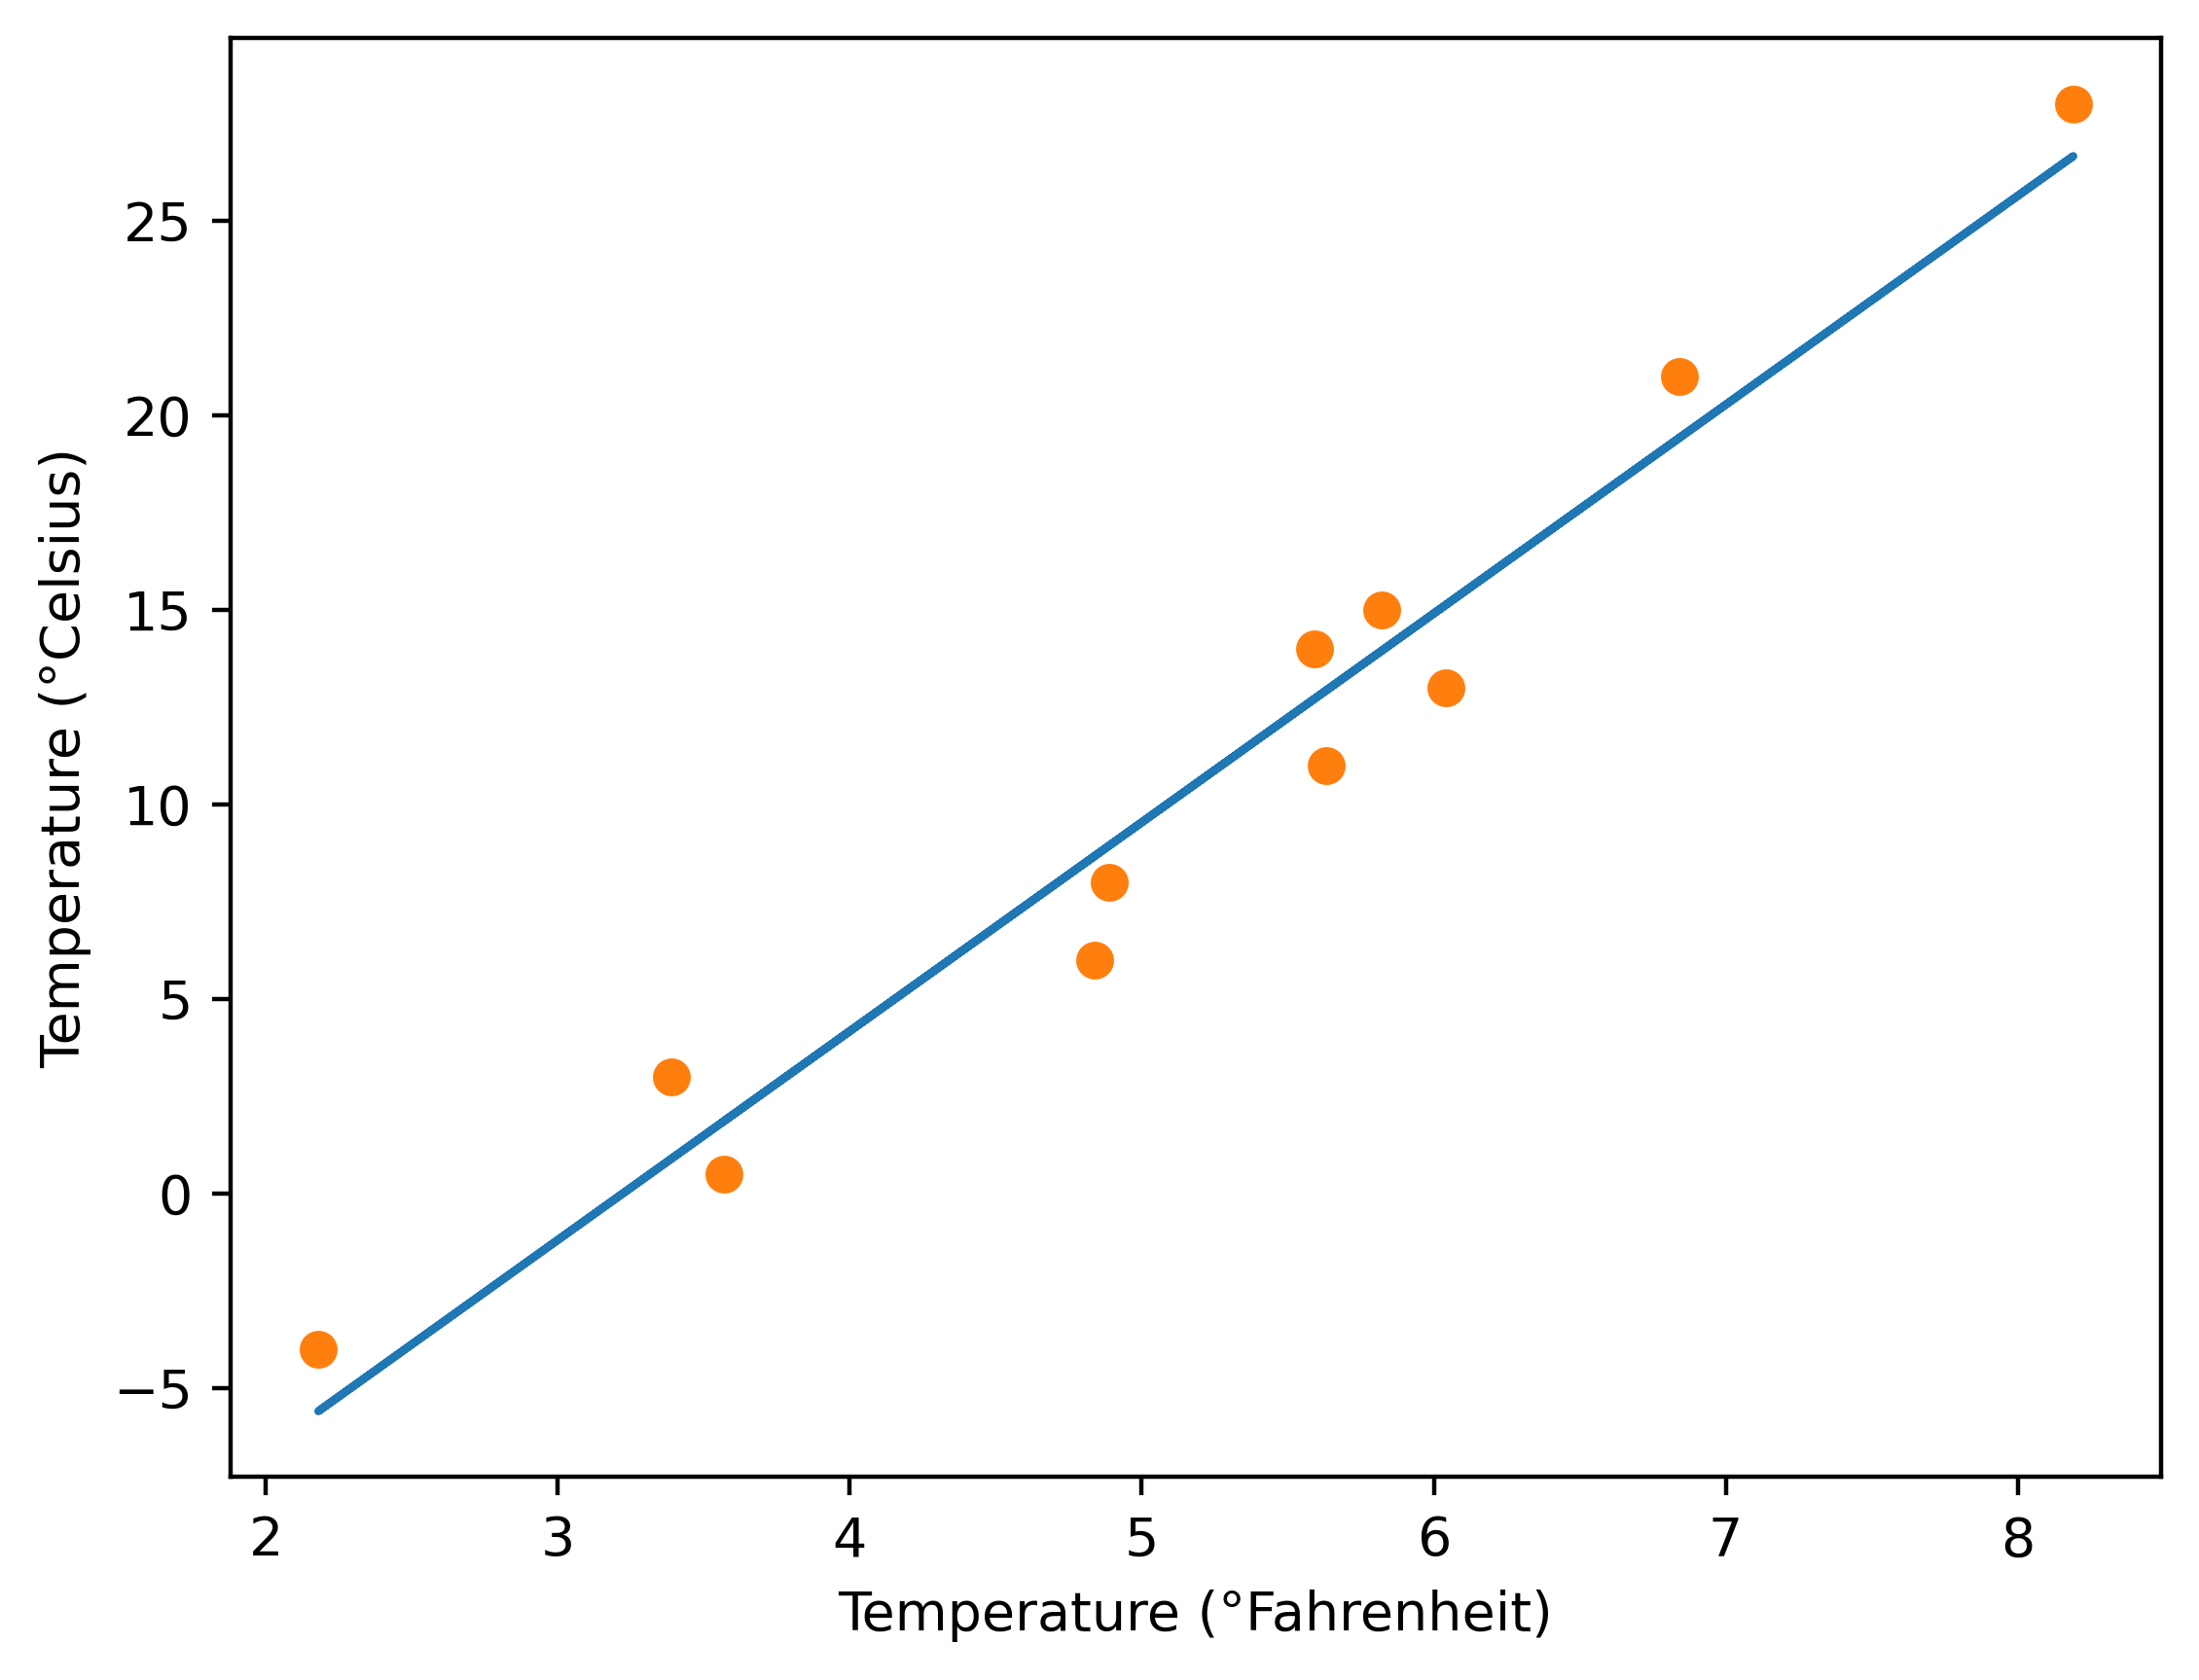

In [43]:
t_p = model(t_u, w, b)

fig = plt.figure(dpi=400)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), "o")
plt.show()

In [45]:
t_p, t_p.requires_grad

(tensor([ 1.8593, 12.7008, 13.9352, 26.6552, 12.9155,  8.9439,  0.8932, -5.6009,
          8.6755, 15.1160, 19.4097]),
 False)

In [48]:
detached_t_p = t_p.detach()
detached_t_p, detached_t_p.requires_grad, id(detached_t_p) == id(t_p)

(tensor([ 1.8593, 12.7008, 13.9352, 26.6552, 12.9155,  8.9439,  0.8932, -5.6009,
          8.6755, 15.1160, 19.4097]),
 False,
 False)

detach()得到的张量与原始张量共享内存数据

In [49]:
detached_t_p[0] = 100.0
detached_t_p, t_p

(tensor([100.0000,  12.7008,  13.9352,  26.6552,  12.9155,   8.9439,   0.8932,
          -5.6009,   8.6755,  15.1160,  19.4097]),
 tensor([100.0000,  12.7008,  13.9352,  26.6552,  12.9155,   8.9439,   0.8932,
          -5.6009,   8.6755,  15.1160,  19.4097]))